This practical work, on motion estimation, has 3 different parts, corresponding to three families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow
- Parametric motion estimation.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
# !pip install opencv-python

In [2]:
import importlib

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

# from me_ssd import me_ssd
import me_ssd
importlib.reload(me_ssd)
from me_ssd import me_ssd

import displayMVF
importlib.reload(displayMVF)
from displayMVF import displayMVF

# from fracMc import fracMc
import fracMc
importlib.reload(fracMc)
from fracMc import fracMc

import PSNR
importlib.reload(PSNR)
from PSNR import PSNR

import me_sad
importlib.reload(me_sad)
from me_sad import me_sad

import HornSchunck
importlib.reload(HornSchunck)
from HornSchunck import HS

from applyAffineMotion import applyAffineMotion
from angle2D import angle2D

import gradient
importlib.reload(gradient)
from gradient import gradient

# from medianFilter import medianFilter
from scipy.ndimage import median_filter

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [3]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3afb981a30>)

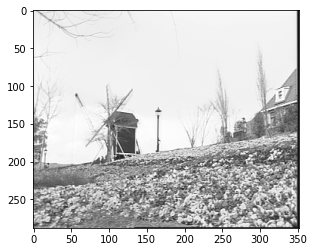

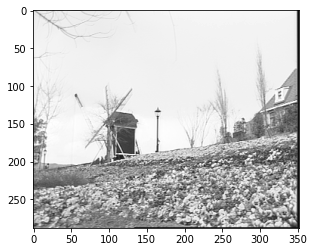

In [4]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3afb83cdf0>)

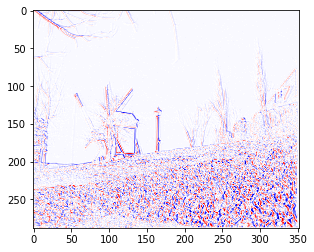

In [5]:
plt.figure(),plt.imshow(im1-im2,cmap='seismic')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [6]:
brow = 16 # Number of rows per block (16)
bcol = 16 # Number of columns per block (16)
search_radius = 8 # Search radius (8)

Code the me_ssd function in the me_ssd file. First, implement the unregularized function.

In [7]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

**Show the motion vector field using the displayMVF function. Write your remarks. Are there errors? If yes, where and why?**

We see that there are errors mainly on the sky, because since it is a homogeneous area, any of the neighbouring blocks in the reference image are similar to the target block in the current image, therefore in the absence of regularization we get random movement vectors on the sky.

**Change the block size and the search area radius. How does it impact your results?**

The decrease of block size or the increase of the search radius makes the results less smooth, this happens because decreasing the block size it is easier to find a block far away that is more similar to the target block than the neighbouring ones, the same when increasing the search radius.

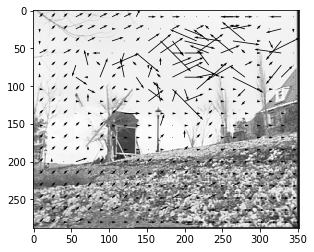

In [8]:
displayMVF(im1,mvf_ssd,brow)

**Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image. Display the motion compensated image. What can you observe ?**

There doesn't seem to be any unnatural distortions on the the compensated image, which is good. However, the flow between the two original images is too small to make a visual diagnosis, therefore it is necessary to use some similarity metric.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3af9f78b50>)

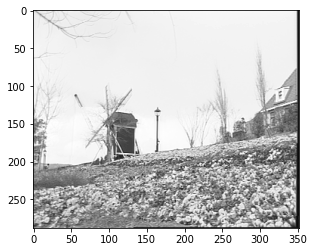

In [9]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

**What is the definition of PSNR ? Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.**

PSNR is the Peak Signal to Noise Ratio, defined as:
$$PSNR = 10 \log \left( \frac{d^2}{EQM} \right)$$
where EQM is the mean squared error between the images and d is the dynamic of the image. The higher the value of the PSNR the better. The PSNR between the motion-compensated image and im2 ($PSNR=22.71$ dB) is better then that between im1 and im2 ($PSNR=18.78$ dB), which is expected since there is an optical flow between the two original images which is compensated on the image we estimated.

**Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.**

Keeping the block size constant and doubling the search radius, the PSNR became $22.71$ dB. On the other hand, keeping the radius constant and dividing by two the block size, the PSNR became $23.23$ dB. So we see that increasing the search radius didn't change much the results, which is expected since the movement between the two images is small, therefore a smaller search radius is already sufficient to account for that movement. However, reducing the block size increased the quality of the compensation since using smaller blocks affords a more precise estimation of the motion.

In [10]:
psnr_ssd = PSNR(im2,im1)
print(psnr_ssd)

18.786509322935075


In [11]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

22.70609398219703


### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [12]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

**Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.**

The results will be discussed bellow.

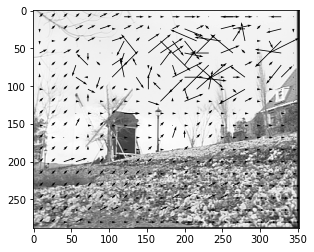

In [13]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

**Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.**

The results obtained for SSD and SAD are quite similar, visually there seems to be no remarkable differences with respect to the regularity of the motion vector field. With respect to PSNR, the results of SSD are only slightly better than for SAD ($22.71$ dB for SSD and $22.62$ dB). The impact of the block size is the same as for SSD.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3af9e58d00>)

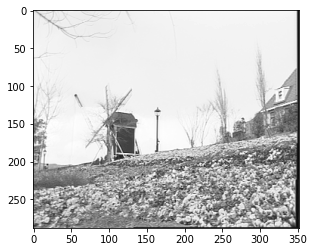

In [14]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [15]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

22.624556595489405


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.

**For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?**

The regularizing function computes the difference between the candidate displacement vector and the median of the displacement vectors for the available neighbours.

**Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?**

Comparing the results to that of the unregularized algorithm, we see that the movement vectors are much more smooth and coherent, there aren't any random movement vectors on the sky anymore. A good trade-off between accuracy and smoothness was obtained for $\lambda=1$.

PSNR(im2, im1):  18.786509322935075
[lambda = 0.01] PSNR(im2, compensated image):  22.706033294296724
[lambda = 0.1] PSNR(im2, compensated image):  22.705878138601598
[lambda = 1] PSNR(im2, compensated image):  22.70538162849112


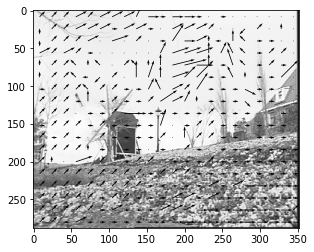

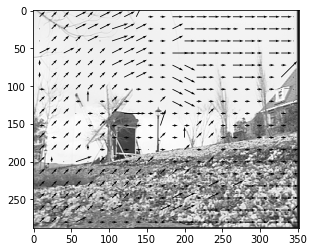

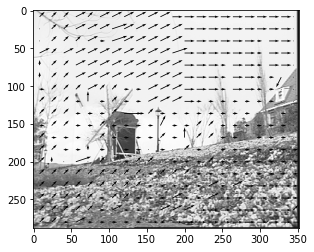

In [16]:
print("PSNR(im2, im1): ", PSNR(im2,im1))

for lamb in [0.01, 0.1, 1]:

    brow = 16 # Number of rows per block (16)
    bcol = 16 # Number of columns per block (16)
    search_radius = 8 # Search radius (8)

    mvf_ssd_reg,prediction =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=lamb)

    displayMVF(im1,mvf_ssd_reg,brow)

    mc_ssd_reg = fracMc(im1,mvf_ssd_reg)

    print("[lambda = {}] PSNR(im2, compensated image): ".format(lamb), PSNR(im2,mc_ssd_reg))

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

**Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.**

Just as with the SSD algorithm, regularization afforded smoother results. However, a good trade-off between accuracy and smoothness was obtained for a smaller value of $\lambda$ ($\lambda=0.1$), which is expected since the SAD dissimilarity metric, by itself, gives smoother results than those of the SSD metric.

PSNR(im2, im1):  18.786509322935075
[lambda=0.01] PSNR(im2, compensated image):  22.614353524490724
[lambda=0.1] PSNR(im2, compensated image):  22.6055846129867
[lambda=1] PSNR(im2, compensated image):  22.560746404323737


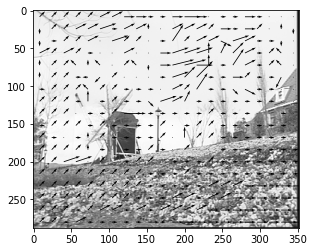

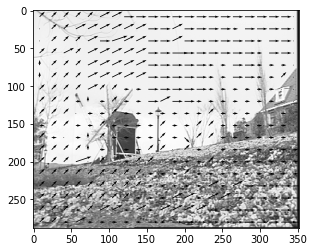

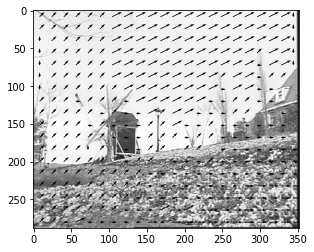

In [17]:
print("PSNR(im2, im1): ", PSNR(im2,im1))

for lamb in [0.01, 0.1, 1]:

    brow = 16 # Number of rows per block (16)
    bcol = 16 # Number of columns per block (16)
    search_radius = 8 # Search radius (8)

    mvf_sad_reg,prediction =  me_sad(im2, im1, brow, bcol, search_radius, lamb=lamb)

    displayMVF(im1,mvf_sad_reg,brow)

    mc_sad_reg = fracMc(im1,mvf_sad_reg)

    print("[lambda={}] PSNR(im2, compensated image): ".format(lamb), PSNR(im2,mc_sad_reg))

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [18]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3af9986670>)

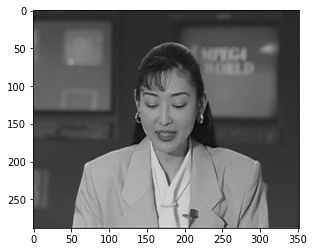

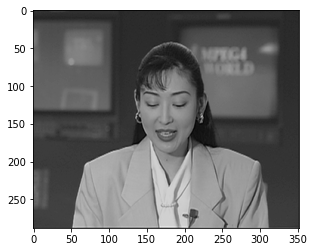

In [19]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithms to initialize you algorithm.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

PSNR(im2, im1):  34.730259700352335
[lambda=0] PSNR(im2, compensated image):  40.30381137893335


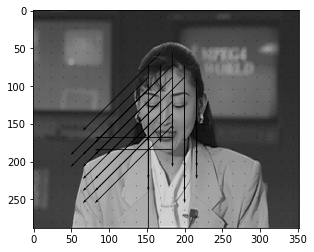

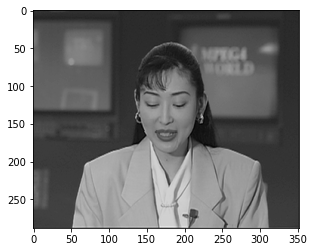

In [20]:
print("PSNR(im2, im1): ", PSNR(im2,im1))

lamb = 0
brow = 16 # Number of rows per block (16)
bcol = 16 # Number of columns per block (16)
search_radius = 13 # Search radius (8)

mvf_sad, _ =  me_sad(im2, im1, brow, bcol, search_radius, lamb=lamb)

displayMVF(im1,mvf_sad,brow)

mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

print("[lambda={}] PSNR(im2, compensated image): ".format(lamb), PSNR(im2,mc_sad))

In [21]:
lamb=0
brow = 16; bcol=16; search_radius =13;
mvf_sad, _ =  me_sad(im2, im1, brow, bcol, search_radius, lamb=lamb)

alpha = 100
ite = 100

uInitial = mvf_sad[:,:,1] # Rem: pay attention to the inversion of the order compare to me_ssd.
vInitial = mvf_sad[:,:,0]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

**Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.**

There is an improvement compared to block-matching algorithms since now we are estimating a dense motion vector field, therefore the small movements of the face can be more precisely estimated, whereas, for the block-matching algorithm, the block size was too big to allow an estimation which was precise enough. Also, the PSNR is higher.

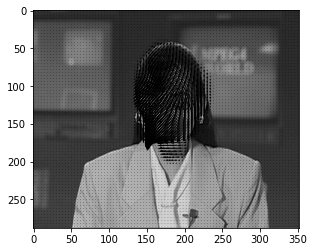

In [22]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [23]:
psnr_hs

40.91985644655179

## End of TP 1

# III - Parametric estimation
In this last part, we will work on parametric estimation, both using direct and indirect methods.
## III-1- Direct parametric estimation
### III-1-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

**Recall the expression of the 2D discrete time Fourier transform (DTFT).**

$$F(u,v) := \operatorname{DTFT}\left\{ f(n,m) \right\} = \sum^{\infty}_{m=-\infty} \sum^{\infty}_{n=-\infty} f(n,m) \exp\left\{-j2\pi (nu+mv)\right\}$$


**Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.**

**Show that the ratio between the DTFTs is:**
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

Computing the DTFT of $b(n,m)$:

$$\begin{aligned}
B(u,v) &= \sum^{\infty}_{m=-\infty} \sum^{\infty}_{n=-\infty} b(n,m) \exp\left\{-j2\pi (nu+mv)\right\} \\
&= \sum^{\infty}_{m=-\infty} \sum^{\infty}_{n=-\infty} a(n+c,m+d) \exp\left\{-j2\pi (nu+mv)\right\} \\
&= \sum^{\infty}_{m'=-\infty} \sum^{\infty}_{n'=-\infty} a(n',m') \exp\left\{-j2\pi \left((n'-c)u+(m'-d)v\right)\right\} \\
&= \exp\left\{j2\pi(cu+dv)\right\} \sum^{\infty}_{m'=-\infty} \sum^{\infty}_{n'=-\infty} a(n',m') \exp\left\{-j2 \pi \left(n'u+m'v\right)\right\} \\
&= \exp\left\{j2\pi(cu+dv)\right\} A(u,v)
\end{aligned}$$

From which we see that:
$$\frac{B(u,v)}{A(u,v)} = \exp\left\{j2\pi(cu+dv)\right\}$$


**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

**Recall the expression of the DTFT.**

$$F[k,l] = \operatorname{DFT}\left\{ f(n,m) \right\} = \sum_{n=0}^{N-1} \sum_{m=0}^{M-1} f(n,m) \exp\left\{-j2\pi\left( \frac{k}{N}n+\frac{l}{N}m\right)\right\}$$


**Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:**
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2j\pi(ck_x + dk_y)}{N^2}\right)
$$

Supposing the expression bellow holds:
$$\frac{A[k,l]}{B[k,l]} = \exp\left(\frac{2j\pi(ck + dl)}{N^2}\right)$$
we have that:
$$\begin{aligned}
A[k,l] &= \exp\left(\frac{2i\pi(ck + dl)}{N^2}\right)B[k,l] \\
\sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m) \exp\left\{-j2\pi\left( \frac{k}{N}n+\frac{l}{N}m\right)\right\} &= \exp\left(\frac{2j\pi(ck + dl)}{N^2}\right) \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} b(n,m) \exp\left\{-j2\pi\left( \frac{k}{N}n+\frac{l}{N}m\right)\right\} \\
\sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m) \exp\left\{-j2\pi\left( \frac{k}{N}n+\frac{l}{N}m\right)\right\} &= \sum_{n=0}^{N-1} \sum_{m=0}^{N-1} b(n,m) \exp\left\{-j2\pi\left( \frac{k}{N}(n-c)+\frac{l}{N}(m-d)\right)\right\} \\
\sum_{n=0}^{N-1} \sum_{m=0}^{N-1} a(n,m) \exp\left\{-j2\pi\left( \frac{k}{N}n+\frac{l}{N}m\right)\right\} &= \sum_{n'=0}^{N-1} \sum_{m'=0}^{N-1} b(n'+c,m'+c) \exp\left\{-j2\pi\left( \frac{k}{N}n'+\frac{l}{N}m'\right)\right\}
\end{aligned}$$
where we assumed that the extended signal is periodic. Therefore, the expression holds if:
$$a(n,m) = b(n+c,m+c)$$

### III-1-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding or not some noise into the image.

In [24]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

# im1 = loadmat('lena.mat')['im1']
# im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3af9baf160>)

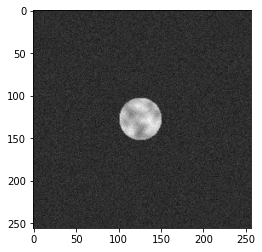

In [25]:
# Potentially add noise to the image
np.random.seed(0)
sigma = 10
im1 = im1 + sigma*np.random.randn(np.shape(im1)[0],np.shape(im1)[1])
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f3af9fa2b20>)

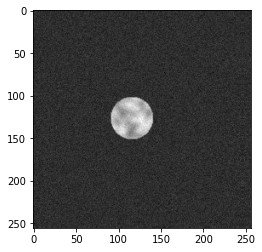

In [26]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

**Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.**

Since the two images differ only by a translation, the translation parameters can be retrieved by computing the Fourier transform of both images and dividing them, which would give:
$$\exp\left\{\frac{2j\pi(ck+dl)}{N^2}\right\}$$
the 2-dimensional angle of the complex argument can then be computed over the $k\times l$ plane and used to estimate the parameters $c$ and $d$ of the translation.

In [27]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

In [28]:
phi = angle2D(IM1/IM2)

**Display phi. Is it a linear plane and why?**

For the *Lena* image, $\phi$ isn't exactly a linear plane, it has the general form of one, but it is very noisy. This is because the DFT assumes periodicity of the signal, however, we did not perform a circular shift on the image, we performed a linear shift and then the left border was filled by reflecting the image along that border, therefore the ratio of the Fourier transforms won't be exactly the exponential expression given above. 

For the *ball* image, whithout noise, $\phi$ is exactly a linear plane, because, since the borders are black, the translation applied ends up corresponding to a circular shift, therefore $\phi$ corresponds to the argument of the exponential expression given above, which is the equation of a linear plane. This isn't the case when we add noise.

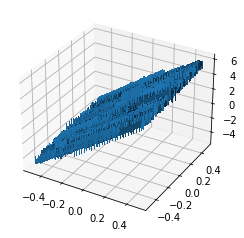

In [29]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [30]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [31]:
print(GX)
print(GY)

9.940005183952252
1.2182523479051497


**Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.**

First of all, $\phi$ was translated so that its center passes through the origin, then the following system was solved for unkowns $\alpha$ and $\beta$:
$$\alpha x+ \beta y = \phi(x,y),\quad \forall x,y$$
which corresponds to finding the least squares planar approximation of $\phi$.

In [32]:
phic = phi-phi[int(N/2+2), int(M/2+2)] # center of the plane now passes through the origin
#t = medianFilter(phi,1) 
t = median_filter(phic,size=3) 

In [33]:
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [34]:
print(bEst)

[9.55001217 1.06407033]


Relaunch the above code:
- with and without noise
- with the lena image, instead of the ball image.

**Each time, are you able to correctly estimate the translation? Why? Comment your results.**

For the *ball* image, without noise, method 1 estimated exactly the translation since the transformation applied to the images corresponds perfectly to the theorical hypothesis that were made. Adding noise, both methods had some small error and, for the *Lena* image, with or without noise, the estimates of both methods had some error, which is due to the fact the we are performing a linear shift instead of a circular one.

# III-2-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

10.0
1.0


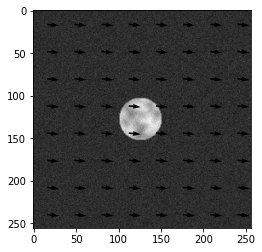

In [35]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im1,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

9.995844593929958
0.999284293287696


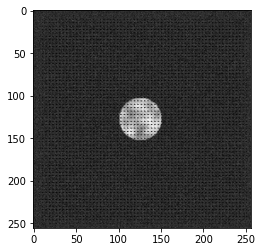

In [36]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

For both the *ball* and the *Lena* image, with or without noise, indirect parametric estimation using block matching could retrieve the translation exactly, which is expected since the whole image is submitted to a same uniform motion, therefore there is no loss in precision when computing the motion for blocks instead of pixels and at the same time this also makes the estimation more robust. Indirect parametric estimation using optic flow also gave good results, but with some small error, since now we are doing a dense motion estimation which is less robust to noise and linear shift distortions. But it is still better then direct parametric estimation, since the later depends on theorical hypothesis that are only perfectly met for the ball image without noise.

It is important to note that noise is added before translation, therefore we are estimating the motion between the noisy original image and the translated noisy image. Adding noise would have a more significant impact on motion estimation if we were comparing the original noiseless image to the translated noisy image.